In [2]:
#imports needed
import numpy as np
import astropy.units as u
import astropy.table as tbl
import matplotlib.pyplot as plt

from ReadFile import Read
from CenterOfMass2 import CenterOfMass
from astropy.constants import G

In [5]:
class MassProfile:
# Class to define 

    def __init__(self, galaxy, snap):
        
        ''' 
        class to find the mass profile of a galaxy 
            
            parameters
            
                galaxy: 
                a string with galaxy name (like MW, M31, etc)
                snap: Snapshot number
            '''
        
        # adding a string of the filename to the value 000
        ilbl = '000'+str(snap)
        # removing all digits except the last 3 
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy)+ilbl+'.txt'
     
        # reading the data in the given file using previously defined Read function
        self.time, self.total, self.data = Read(self.filename)                                                                                             

        # storing the positions, velocities, & mass
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        self.vx = self.data['vx']*u.km/u.s
        self.vy = self.data['vy']*u.km/u.s
        self.vz = self.data['vz']*u.km/u.s
        self.m = self.data['m']
        
        #set the galaxy name as a global property
        self.gname = galaxy
        
    def MassEnclosed(self, ptype, radii):
        '''
        this function will compute the enclosed mass 
        for a given radius of the COM position for a particular galaxy's component.

        inputs:
            ptype:
                the particle type to use for COM calculations (1, 2, 3)
            radii: 
                an array of radii in magnitude

        outputs: 
            masses_enclosed: 
                an array of enclosed mass at each particular radius specified
                in units of M_sun 

        '''
        #creating the CenterOfMass objects and calling previously defined COM_P
        COM = CenterOfMass(self.filename,ptype)
        COM_p = COM.COM_P(0.1, volDec=2.0)
        print(COM_p)
        
        
        index = np.where(self.data['type'] == ptype)
        
        #loop over the radius array to define particles that are enclosed within the radius given
        
        self.m_new = self.m[index]
        
        masses_enclosed = np.zeros(len(radii))
        for i in range(len(radii)):
            
            distance_magnitude = np.sqrt((self.x[index]-COM_p[0])**2 
                                         +(self.y[index]-COM_p[1])**2 
                                         +(self.z[index]-COM_p[2])**2)
            
            enclosed_index = np.where(distance_magnitude/u.kpc < radii[i])
            
            #storing the sum of masses of the particles within the particular radius
            masses_enclosed[i]= sum(self.m_new[enclosed_index])
            
        return masses_enclosed * 1e10 *u.Msun
    
    def MassEnclosedTotal(self, radii):
        ''' this calculates the total enclosed mass from each particle type
        
        inputs:
            radii: 
                array of radii to calculate the enclosed mass at each point
        
        outputs:
            total_mass: 
                array of the toal mass enclosed at each radii in M_sun
        
        '''
        
        # calulating the mass enclosed for each particle type
        halo_mass = self.MassEnclosed(1, radii)
        disk_mass = self.MassEnclosed(2, radii)
        if self.gname != 'M33': # M33 doesn't have a buldge mass, so we skip it
            bulge_mass = self.MassEnclosed(3, radii)  
            total_mass = halo_mass + disk_mass + bulge_mass
        else:
            total_mass = halo_mass + disk_mass
            
        return total_mass
    
    def HernquistMass(self, radii, a, M_halo):
        '''
        computes the mass enclosed within a particular radius
        
        inputs:
            radius: 'array'
                an array of radii values
            a: 'float'
                hernquist scale factor
            M_halo: 'array'
                the halo mass of the galaxy
            
        outputs:
            M: the mass enclosed at a given radius in M_sun
            
        '''
        
        # hernquist mass profile
        
        M = (M_halo*radii**2/(a+radii)**2 )*u.Msun
            
        return M
    
    def CircularVelocity(self, ptype, radii, G):
        '''
        this function calculates the circular speed at each particular radii.
        
        inputs:
            ptype: 
                particle type (as a float)
            radii: 
                an array of radii for the circular speed to be calculated at 
            G: 
                gravitational constant in kms units
        
        output:
            Vcirc:
                an array of circular speeds with units km/s, rounded to two decimal places
        
        '''
        
        G = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # converting the units
        
        # finding mass enclosed
        M_enclosed = self.MassEnclosed(ptype, radii)
        
        # applying circular speed formula
        Vcirc = np.round(np.sqrt(G*M_enclosed/(radii*u.kpc)), 2)
        
        #print(Vcirc)
        
        return Vcirc
    
    def CircularVelocityTotal(self, radii, G):
        '''
        this function calculates the total circular velocity 
        representing the total Vcirc created by all the galaxy components
        at each particular radius from the input array
        
        inputs:
            radii:
                an array of radii
            
            G:
                gravitational constant in kms units
        
        outputs:
            total_Vcirc:
                an array of circular velocity (in units of km/s)
                
        '''
        
        # calculating circular velocity for each of the particle types
        halo_Vcirc = self.CircularVelocity(1, radii, G)
        disk_Vcirc = self.CircularVelocity(2, radii, G)
        if self.gname != 'M33': # M33 doesn't have a buldge mass, so we skip it
            bulge_Vcirc = self.CircularVelocity(3, radii, G)  
            total_Vcirc = halo_Vcirc + disk_Vcirc + bulge_Vcirc
        else:
            total_Vcirc = halo_Vcirc + disk_Vcirc
            
        return total_Vcirc
    
    def HernquistVcirc(self,radius,a, M_halo, G):
        '''
        this function computes the circular speed using the hernquist mass profile
        
        inputs:
            radius:
                an array of radii for the circular speed to be computed at
            a: 
                Hernquist scale factor (float)
            M_halo:
                an array of the halo mass of the galaxy
            
        
        '''
        
        G = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # converting units
        
        Mass_Hern = self.HernquistMass(radius,a,M_halo) # calculating the hernquist mass
        
        Vcirc = np.round(np.sqrt(G*Mass_Hern/(radius*u.kpc)), 2) #round and add units
        
        print(Vcirc)
        
        return Vcirc
    
    def DensityEnclosed(self, ptype, radii, volDec):
        '''
        this function will compute the enclosed density 
        for a given radius of the COM position for M31 and MW

        inputs:
            ptype:
                the particle type to use for COM calculations (1, 2, 3)
            radii: 
                an array of radii in magnitude

        outputs: 
            density_enclosed: 
                an array of enclosed density at each particular radius specified 
                '''
        
        #creating the CenterOfMass objects and calling previously defined COM_P
        COM = CenterOfMass(self.filename, 2)
        COM_p = COM.COM_P(0.1,volDec=2.0)
       
        index = np.where(self.data['type'] == ptype)
        density_enclosed = np.zeros(len(radii)-1)
        #loop over the radius array to define particles that are enclosed within the radius given
        self.m_new = self.m[index]
        distance_magnitude = np.sqrt((self.x[index]-COM_p[0])**2 +(self.y[index]-COM_p[1])**2 +(self.z[index]-COM_p[2])**2)
        for i in range(len(density_enclosed)):
            enclosed_index = np.where((distance_magnitude/u.kpc > radii[i]) & (distance_magnitude/u.kpc <= radii[i+1]))
            
            density_enclosed[i] = np.sum(self.m_new[enclosed_index])/(((4*np.pi)/3)*((radii[i+1])**3 -(radii[i])**3))
        
        return density_enclosed * 1e10*u.Msun
    
    def HernquistDensity(self, radii, a, M_tot):
        '''
        computes the density enclosed within a particular radius
        inputs: 
        radii: 'array'
        an array of radii values
            
        a: 'float'
        hernquist scale factor
        M_tot: #look at the numbers from HW3 and add together 
        '''
        rho =  (M_tot/2*np.pi)*(a/radii)*(1/(radii+a)**3) #hernquist density equation              
        return rho
    
    

# Milky Way Density Profile

In [22]:
MW = MassProfile("MW", 0) # initializing MW classs

In [23]:
r = np.arange(0.1, 30.5, 0.5) # radius range we are using up to 30kpc
r_without_last = np.delete(r, -1)
r_without_first = np.delete(r, 0)
r_new = ((r_without_last)+(r_without_first))/2
total_density_enclosed_MW0 = MW.DensityEnclosed(1, r, volDec=2.0)

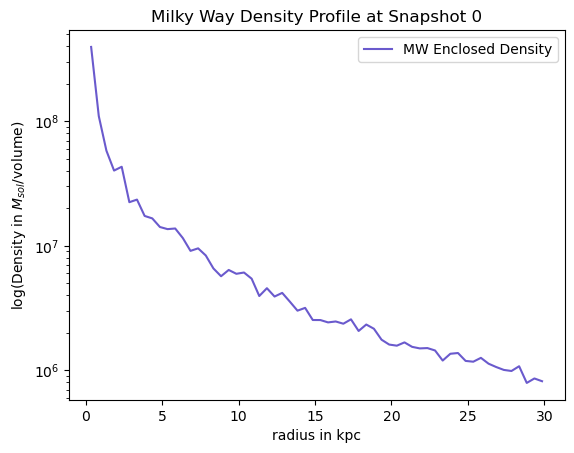

In [31]:
# plotting MW mass profile

plt.semilogy(r_new, total_density_enclosed_MW0,label="MW Enclosed Density", c="slateblue")
plt.ylabel("log(Density in $M_{sol}$/volume)")
plt.xlabel('radius in kpc')
plt.legend()
plt.title("Milky Way Density Profile at Snapshot 0" )
plt.savefig("MW Density Profile Snap 0.pdf")


## M31 Density Profile

In [26]:
M31 = MassProfile("M31", 0) # initializing MW classs

In [27]:
r = np.arange(0.1, 30.5, 0.5) # radius range we are using up to 30kpc
r_without_last = np.delete(r, -1)
r_without_first = np.delete(r, 0)
r_new = ((r_without_last)+(r_without_first))/2
total_density_enclosed_M310 = M31.DensityEnclosed(1, r, volDec=2.0)
print(total_density_enclosed_M310)

[42658284.59180973 98707062.10481527 63023179.94847838 71028315.0996251
 37502352.41925786 22525250.56219178 19577534.70148872 18124741.62310894
 13556371.98184204 14283851.48798386 14088701.46299966 10356250.53752297
  7123225.0813887  10550224.04553528  7580245.35305026  9125408.20014056
  6136855.92990237  6477786.56801978  6922438.05540099  4536463.06104637
  5021900.53496587  4517867.75353057  3416812.38445251  3787640.15517434
  4208687.25677995  3628403.83646299  3087306.89077298  3250903.27558385
  2731433.78996163  2439716.29000209  2880171.90325361  2530983.88938443
  2309950.1263323   2045702.69370112  1827949.03690835  2417777.30501632
  2215192.19354636  1669068.45991612  1681905.96224729  1753416.33180449
  1579733.00231736  1673649.91034013  1274261.57055087  1626419.13634339
  1432066.81957118  1569154.29235911  1379320.95887513  1160864.87576758
  1185864.96352377  1326746.49454024  1094153.92315332  1107136.89489949
   924624.9690692    966839.33119594   890943.839625

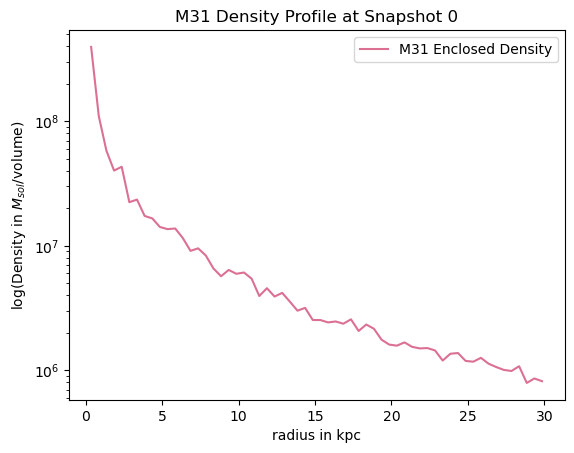

In [30]:
# plotting M31 density profile

plt.semilogy(r_new, total_density_enclosed_MW0,label="M31 Enclosed Density", c="palevioletred")
plt.ylabel("log(Density in $M_{sol}$/volume)")
plt.xlabel('radius in kpc')
plt.legend()
plt.title("M31 Density Profile at Snapshot 0" )
plt.savefig("M31 Density Profile Snap 0.pdf")